In [1]:
import pandas as pd
import datetime
import numpy as np
from numpy import exp,pi,sin,cos,sinh,sqrt,roots
import matplotlib as mpl
import matplotlib.pyplot as plt
# import matplotlib.font_manager as fm

from Parameters import Const
from MEWs_Funcs import Spec_q,Spec_w,Spec_w_b20,Spec_dipol_w
from My_Int import Int3D,Int2D

In [2]:
# Day,  data and year
day_month_y = datetime.date.today().strftime('%d%B%y')
print('Data: '+day_month_y)

Data: 01July22


# Parameters

In [3]:
x = 'YIG'

kb = 1.380649e-16
# R =  8.31446261815324 # J/mol/K
mb,hp,g,ge,Ka,ro,a0,c11,c12,c44,M0,A,b2,al = Const(x)

V_molar = (3*88.906 + 5*55.845 + 12*15.999)/ro # Molar Volume cm^3/mol
qD = (6*pi**2)**(1/3)/a0
gamma = {'YIG':0,'x=0':4.89e-3,'x=0.09':5.03e-3,'x=0.154':4.46e-3,'x=0.175':4.69e-3,'x=0.194':5.21e-3}   # electron term

print('c11 =','%.4e' %c11,'c12 =','%.4e' %c12,'c44 =','%.4e' %c44,'ro =','%.4f' %ro)
print('a =','%.4e' % a0,'M0 =', '%.4f' %M0,'A =','%.4e' %A,'b2 =','%.4e' %b2,'al =',al)
print('Molar Volume V_molar =', '%.4f' %V_molar, 'cm^3/mol','\n', 'q_D =', '%.2e' % qD, '1/cm')

c11 = 2.6900e+12 c12 = 1.0770e+12 c44 = 7.6400e+11 ro = 5.1700
a = 1.2376e-07 M0 = 139.2606 A = 4.3000e-07 b2 = 4.3635e+06 al = 0
Molar Volume V_molar = 142.7333 cm^3/mol 
 q_D = 3.15e+07 1/cm


# Heat Capacity 
$C_V = \left( \dfrac{\partial \varepsilon}{\partial T} \right)_V$

In [4]:
H0 = 2940
H = 2*Ka/M0 + H0

T0,Tf = 0.01, 100
n = np.linspace(0,np.log10(Tf/T0),100)
T_array = T0*10**n
# T_array = np.ones(1)

## 1. Phonon and magnon interacts

In [5]:
Cv = np.zeros([T_array.size,4])

zz = 15
# a1,b1,zz1 = 0, 2*pi/a0, 30  # q
a2,b2,zz2 = 0, pi/2,    zz  # theta
a3,b3,zz3 = 0, pi/2,    zz  # fi

ST_111 = sqrt((c44-c12+c11)/(3*ro))
kk = [8,16,22,45]

for Temp in T_array:
    ii, =  np.where(np.isclose(T_array, Temp))
    ii = ii.item()

    f = lambda q,t,fi: np.sort(np.real(Spec_dipol_w(q,t,fi,x,H)))[::-1]
    w = lambda q,t,fi: f(q,t,fi)[f(q,t,fi)>0]
    z = lambda q,t,fi: hp*w(q,t,fi)/(kb*Temp)
    Podint = lambda q,t,fi: (z(q,t,fi)/sinh(z(q,t,fi)/2))**2
    
    for mode in range(4):     
        qmax = kk[mode]*kb*Temp/hp/ST_111
        if qmax>qD:
            qmax = qD
        a1,b1,zz1 = 0, qmax, zz  # q
        Fun = lambda q,t,fi: sin(t)*q**2*Podint(q,t,fi)[mode]
        res = 8*Int3D(Fun,a1,b1,zz1,a2,b2,zz2,a3,b3,zz3)
        Cv[ii,mode] = V_molar*res*kb/(4*(2*pi)**3)*1e-7  #Дж/моль/K

    df = pd.DataFrame(data=Cv, columns =["1", "2", "3", "4"])
    df.insert(0, "T, K", T_array)
    df.to_csv('Data\Cv_YIG_'+day_month_y+'.csv', sep='\t',index=False)

## 2. Electron, Phonon and magnon separate ($q_D \rightarrow \infty$)


In [6]:
Cv_0 = np.zeros([T_array.size,5])
velocity = np.zeros(3)
T_D = np.zeros(3)

a1,b1,zz1 = 0, pi/2,    100  # theta
a2,b2,zz2 = 0, pi/2,    100  # fi
    
S_0 = lambda t,fi: np.real(Spec_w_b20(1,t,fi,x,H))
Podint_0 = lambda t,fi: 1/S_0(t,fi)**3

for mode in range(3):
    Fun_0 = lambda t,fi: sin(t)*Podint_0(t,fi)[mode]
    res_0 = 8*Int2D(Fun_0,a1,b1,zz1,a2,b2,zz2)
    velocity[mode] = res_0**(-1/3)
    T_D[mode] = hp*velocity[mode]/kb*(12*pi**2)**(1/3)/a0
    Cv_0[:,mode] = V_molar*kb*(kb*T_array/hp)**3*pi/30*res_0*1e-7   #Дж/моль/K
    # Cv_0[:,mode] = 6*pi**4/5*R*(T_array/T_D[mode])**3   #Дж/моль/K
    # Cv_0[:,mode] = kb*(kb*T_array/hp)**3*pi/30*res_0

# Magnon
I52 = 17.83293191
Cv_0[:,3] = V_molar*kb/(16*pi**2)*(M0*kb*T_array/(2*ge*A*hp))**(3/2)*I52*1e-7    #Дж/моль/K

#Electron
Cv_0[:,4] = gamma['YIG']*T_array  #Дж/моль/K

df = pd.DataFrame(data=Cv_0, columns =["1", "2", "3", "4", "5"])
df.insert(0, "T, K", T_array)
df.to_csv('Data\Cv0_YIG_'+day_month_y+'.csv', sep='\t',index=False)

Cv_0_Tot_ph = Cv_0[:,0] + Cv_0[:,1] + Cv_0[:,2]

Cv_0_Tot_ph_m = Cv_0_Tot_ph + Cv_0[:,3]
Cv_0_Tot_ph_e = Cv_0_Tot_ph + Cv_0[:,4]
Cv_0_Tot = Cv_0_Tot_ph + Cv_0[:,3] + Cv_0[:,4]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


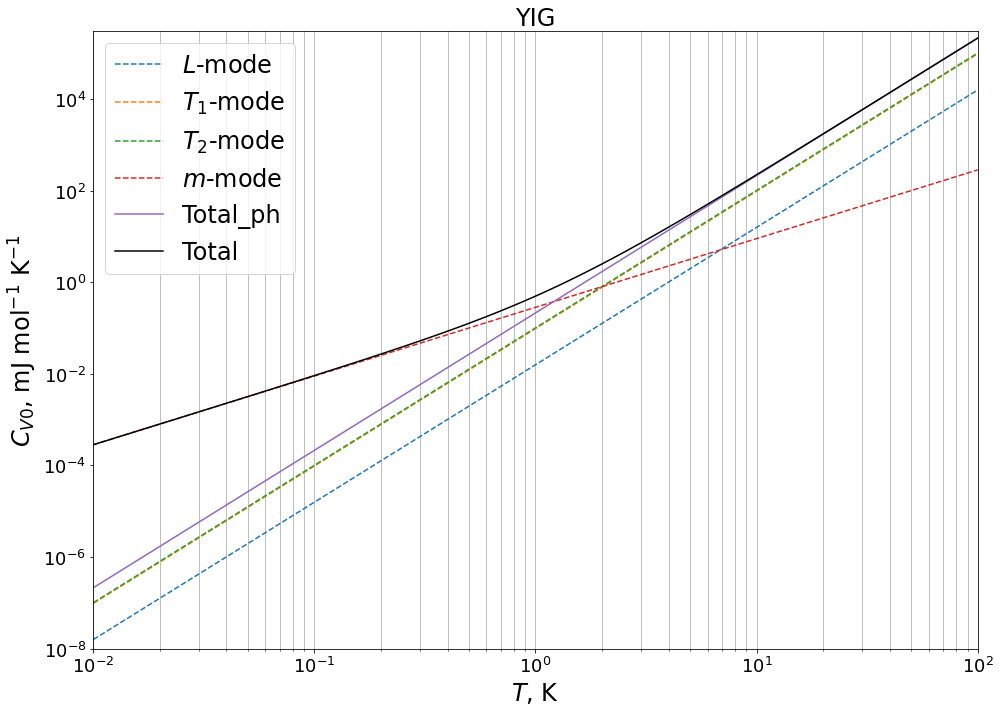

In [10]:
fig, ax = plt.subplots(1,1, figsize=(14, 10))
ax.loglog(T_array, Cv_0[:,0]*1e3,'--', label = '$L$-mode')
ax.loglog(T_array, Cv_0[:,1]*1e3,'--', label = '$T_1$-mode')
ax.loglog(T_array, Cv_0[:,2]*1e3,'--', label = '$T_2$-mode')
ax.loglog(T_array, Cv_0[:,3]*1e3,'--', label = '$m$-mode')
ax.loglog(T_array, Cv_0_Tot_ph*1e3, label = 'Total_ph')
ax.loglog(T_array, Cv_0_Tot*1e3, color='black', label = 'Total')
ax.set_xlabel('$T$, K', fontsize=24)
ax.set_ylabel('$C_{V0}$, mJ mol$^{-1}$ K$^{-1}$', fontsize=24)
ax.set_xlim([1e-2,100])
ax.set_ylim([1e-8,3e5])
ax.legend(fontsize=24)
ax.grid(which='both',axis='x')
plt.title(str(x), fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
fig.savefig('Figs\Cv0_YIG_vs_T_'+day_month_y+'.eps')
plt.show()

## 3. Electron, Phonon and magnon separate ($q_D$ is limited)

In [11]:
Cv_01 = np.zeros([T_array.size,4])

zz = 30
# a1,b1,zz1 = 0, 2*pi/a0, 30  # q
a2,b2,zz2 = 0, pi/2,    zz  # theta
a3,b3,zz3 = 0, pi/2,    zz  # fi

ST_111 = sqrt((c44-c12+c11)/(3*ro))
kk = [8,16,22,45]

for Temp in T_array:
    ii, =  np.where(np.isclose(T_array, Temp))
    ii = ii.item()

    w = lambda q,t,fi: np.real(Spec_w_b20(q,t,fi,x,H))
    z = lambda q,t,fi: hp*w(q,t,fi)/(kb*Temp)
    Podint = lambda q,t,fi: (z(q,t,fi)/sinh(z(q,t,fi)/2))**2
    
    for mode in range(4):     
        qmax = kk[mode]*kb*Temp/hp/ST_111
        if qmax>qD:
            qmax = qD
        a1,b1,zz1 = 0, qmax, zz  # q
        Fun = lambda q,t,fi: sin(t)*q**2*Podint(q,t,fi)[mode]
        res = 8*Int3D(Fun,a1,b1,zz1,a2,b2,zz2,a3,b3,zz3)
        Cv_01[ii,mode] = V_molar*res*kb/(4*(2*pi)**3)*1e-7  # J/mol/K

    df = pd.DataFrame(data=Cv_01, columns =["1", "2", "3", "4"])
    df.insert(0, "T, K", T_array)
    df.to_csv('Data\Cv01_'+day_month_y+'.csv', sep='\t',index=False)

In [12]:
C_v = pd.read_csv('Data\Cv_YIG_'+day_month_y+'.csv',sep = '\t')

Cv_01_Tot = Cv_01[:,0] + Cv_01[:,1] + Cv_01[:,2] + Cv_01[:,3]
Cv_Tot = C_v['1'] + C_v['2'] + C_v['3'] + C_v['4']

rel = Cv_Tot/Cv_01_Tot

## Plotting

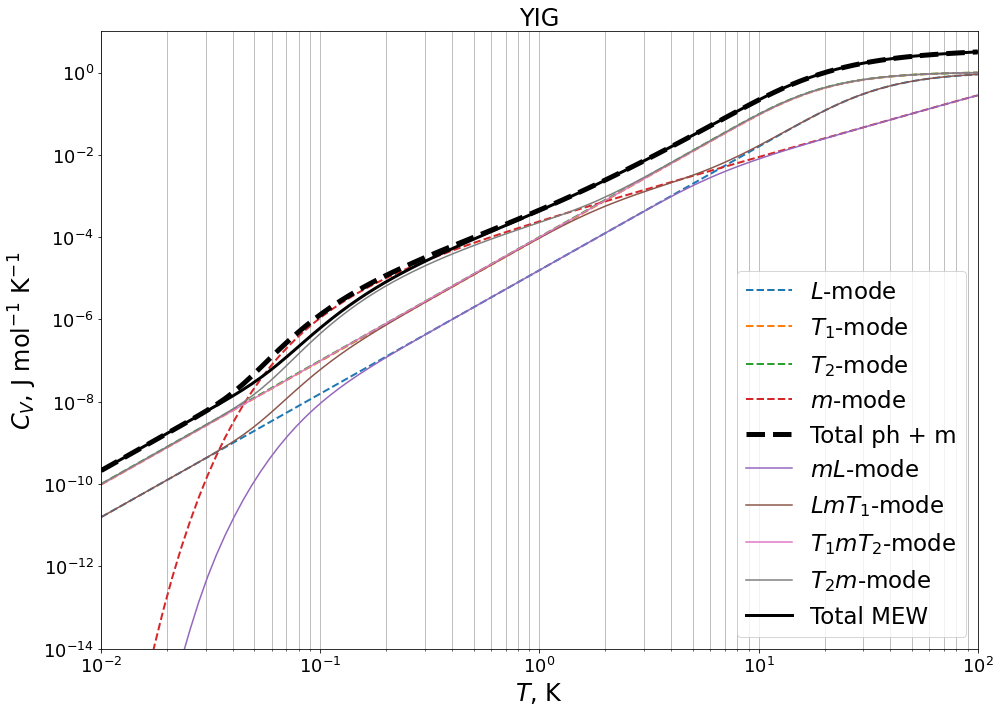

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [16]:
fig, ax = plt.subplots(1,1, figsize=(14, 10))
ax.loglog(T_array, Cv_01[:,0],'--', linewidth=2, label = '$L$-mode')
ax.loglog(T_array, Cv_01[:,1],'--', linewidth=2, label = '$T_1$-mode')
ax.loglog(T_array, Cv_01[:,2],'--', linewidth=2, label = '$T_2$-mode')
ax.loglog(T_array, Cv_01[:,3],'--', linewidth=2, label = '$m$-mode')
ax.loglog(T_array, Cv_01_Tot, linewidth=5, linestyle='--', label = 'Total ph + m',color = 'black')
ax.loglog(C_v['T, K'], C_v['1'], label = '$mL$-mode')
ax.loglog(C_v['T, K'], C_v['2'], label = '$LmT_1$-mode')
ax.loglog(C_v['T, K'], C_v['3'], label = '$T_1mT_2$-mode')
ax.loglog(C_v['T, K'], C_v['4'], label = '$T_2m$-mode')
ax.loglog(C_v['T, K'], Cv_Tot, linewidth=3, label = 'Total MEW',color = 'black')
ax.set_xlabel('$T$, K', fontsize=24)
ax.set_ylabel('$C_V$, J mol$^{-1}$ K$^{-1}$', fontsize=24)
ax.set_xlim([1e-2,100])
ax.set_ylim([1e-14,10])
ax.legend(fontsize=23)
ax.grid(which='both',axis='x')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title(str(x), fontsize=24)
plt.tight_layout()
plt.show()
fig.savefig('Figs\Cv_YIG_vs_T_'+day_month_y+'.eps')
plt.close()

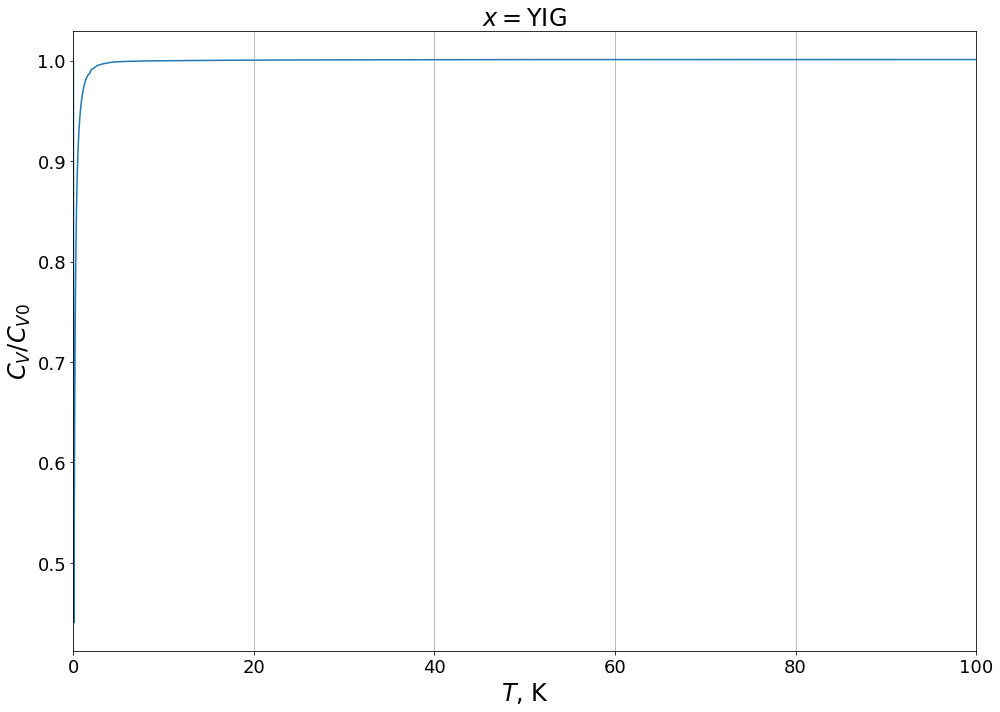

In [17]:
fig, ax = plt.subplots(1,1, figsize=(14, 10))
#ax.loglog(T_array, Cv_0[:,0],'--', linewidth=3)
ax.plot(T_array, rel)
ax.set_xlabel('$T$, K', fontsize=24)
ax.set_ylabel('$C_V/C_{V0}$', fontsize=24)
ax.set_xlim([0,100])
# ax.set_ylim([0,1])
ax.grid(which='both',axis='x')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('$x =$'+str(x), fontsize=24)
plt.tight_layout()
plt.show()
fig.savefig('Figs\Rel_YIG_vs_T_'+day_month_y+'.eps')
plt.close()

# Integrand vs $q$

In [30]:
x = 0.18
H0 = 2940
H = 2*Ka/M0 + H0

T_array = np.linspace(0.05,0.15,6)
q_array = np.linspace(1e-5,4e6,100)

ST_111 = sqrt((c44-c12+c11)/(3*ro))
kk = [8,16,22,45]

Pod = np.zeros([q_array.size,4,T_array.size])
qmax = np.zeros([4,T_array.size])

a1,b1,zz1 = 0, pi/2,    3  # theta
a2,b2,zz2 = 0, pi/2,    3  # fi

for Temp in T_array:
    ii, = np.where(np.isclose(T_array, Temp))
    ii = ii.item()
    for qq in q_array:
        jj, = np.where(np.isclose(q_array, qq))
        jj = jj.item()
        for mode in range(4):
            f = lambda t,fi: np.sort(np.real(Spec_w(qq,t,fi,x,H)))[::-1]
            w = lambda t,fi: f(t,fi)[f(t,fi)>0]
            z = lambda t,fi: hp*w(t,fi)[mode]/(kb*Temp)
            Fun_tf = lambda t,fi: (z(t,fi)/sinh(z(t,fi)/2))**2*sin(t)
            Pod[jj,mode,ii] = qq**2*Int2D(Fun_tf,a1,b1,zz1,a2,b2,zz2)*2/pi
            qmax[mode,ii] = kk[mode]*kb*Temp/hp/ST_111

    print(ii+1, ' max =', len(T_array))


1  max = 6
2  max = 6
3  max = 6
4  max = 6
5  max = 6
6  max = 6


## Plotting

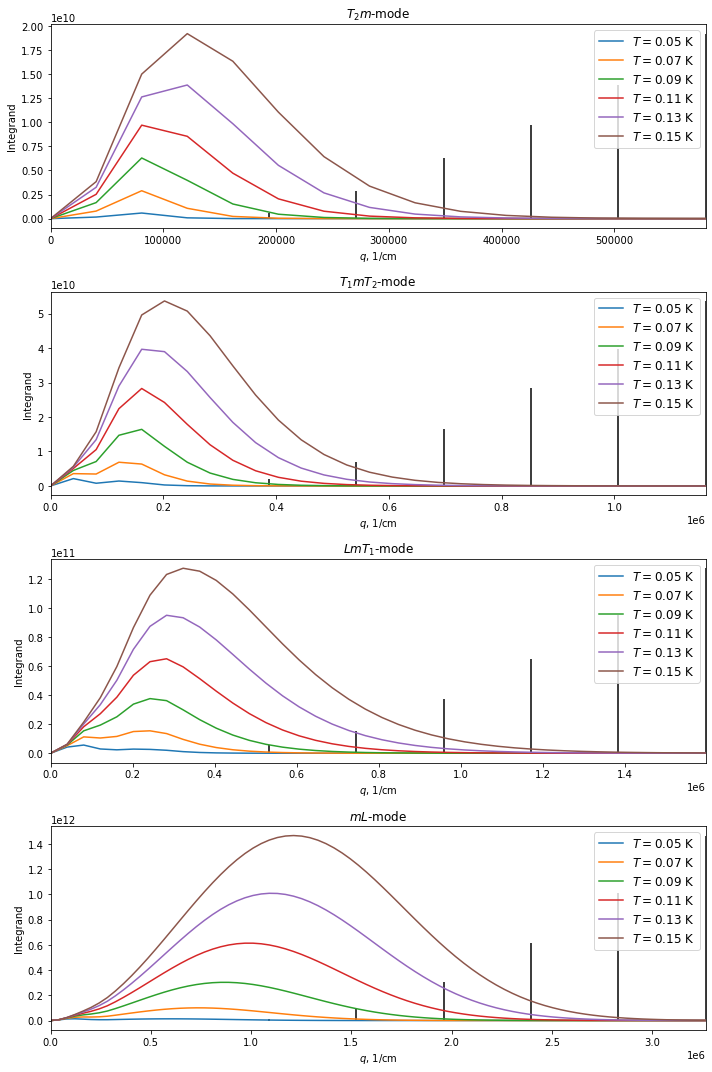

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [31]:
mode_name = ['$mL$-mode','$LmT_1$-mode','$T_1mT_2$-mode','$T_2m$-mode']

fig, ax = plt.subplots(4,1, figsize=(10, 15))

for ii in range(len(T_array)):
    for jj in range(4):
        ax[jj].plot(q_array, Pod[:,jj,ii], label=r'$T =$'+ "{:.2f}".format(T_array[ii]) + ' K')
        ax[jj].vlines(qmax[jj,ii], Pod[:,jj,ii].min(), Pod[:,jj,ii].max(),'black')
        ax[jj].set(xlabel='$q$, 1/cm', ylabel='Integrand')
        ax[jj].grid()
        ax[jj].legend(fontsize=12)
        ax[jj].set_title(mode_name[jj])
        ax[jj].set_xlim([0,qmax[jj,:].max()])
plt.tight_layout()
plt.show()
fig.savefig('Figs\Cv_YIG_vs_q_'+day_month_y+'.eps')

In [37]:
print(qmax)

[[ 363028.76340782  605047.93901303  847067.11461825 1089086.29022346]
 [ 484038.35121043  806730.58535071 1129422.819491   1452115.05363128]
 [ 605047.93901303 1008413.23168839 1411778.52436375 1815143.8170391 ]
 [ 968076.70242085 1613461.17070142 2258845.63898199 2904230.10726256]]
